## 3-2-1 EDA_RMSE_MAE_Plots

In [1]:
# Import the necessary libraries

import os 
import pandas as pd
import numpy as np
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt


### Load the datasets

In [2]:
# Define a list of states for which datasets will be loaded
state_list = ['Texas', 'Iowa', 'Nevada', 'Seattle']

# Define the base folder path where the datasets are located
base_folder_path = './Data/'

# Create an empty dictionary to store DataFrames
dfs = {}

# Loop through each state and load the corresponding dataset
for state in state_list:
    # Construct the file path for the dataset of the current state
    file_path = os.path.join(base_folder_path, f'{state}_0_18.csv')
    
    # Define a key for the DataFrame in the dictionary
    df_key = f'df_{state}'
    
    # Load the dataset into a Pandas DataFrame and store it in the dictionary
    dfs[df_key] = pd.read_csv(file_path)

# List the keys (DataFrame names) stored in the 'dfs' dictionary
loaded_datasets = list(dfs)
print(loaded_datasets)

['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']


### Convert the datetime from UTC to LST (Local Standard Time)

In [3]:
# Define a dictionary that maps state names to their corresponding latitude and longitude coordinates
locations = {
    'Texas': (30.6095651015, -96.3402969602),
    'Nevada': (36.089758655, -115.1833049303),
    'Iowa': (42.0135891695, -93.6356966723),
    'Seattle': (48.6108182606, -123.1479221551)
}

# Initialize a TimezoneFinder instance to determine timezones based on coordinates
tf = TimezoneFinder()

# Assuming 'dfs' is your dictionary of DataFrames
for df_key in dfs:
    # Extract the state name from the DataFrame key
    state = df_key.split('_')[1]

    # Retrieve the latitude and longitude for the state from the 'locations' dictionary
    latitude, longitude = locations[state]

    # Find the timezone for the given latitude and longitude using the TimezoneFinder
    local_timezone = tf.timezone_at(lat=latitude, lng=longitude)

    # Convert the 'datetime' column in the DataFrame to datetime objects
    dfs[df_key]['datetime'] = pd.to_datetime(dfs[df_key]['datetime'])

    # Set the timezone of the 'datetime' column to UTC
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_localize('UTC')

    # Convert the 'datetime' column to the local timezone
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_convert(local_timezone)
    dfs[df_key]['datetime'] = dfs[df_key]['datetime'].dt.tz_localize(None)

### Calculate MAE

In [4]:
# Function to calculate Mean Absolute Error (MAE) for specific hours in a DataFrame
def calculate_mae_for_specific_hours(df, specific_hours):
    # Extract the hour component from the 'datetime' column
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour

    # Filter the ground truth data (forecast value equals 0)
    ground_truth_data = df[df['forecast'] == 0]

    # Initialize an empty list to hold the MAE data
    mae_data = []

    # Loop over the specific hours for MAE calculation
    for hour in specific_hours:
        # Filter the ground truth data for the specific hour
        ground_truth_hourly = ground_truth_data[ground_truth_data['hour'] == hour]

        for forecast_value in range(1, 19):
            # Filter the forecast data for the specific hour and forecast value
            forecast_data_hourly = df[(df['forecast'] == forecast_value) & (df['hour'] == hour)]
            if not forecast_data_hourly.empty:
                # Merge the ground truth and forecast data based on 'datetime'
                merged_data = pd.merge(ground_truth_hourly, forecast_data_hourly, on='datetime', suffixes=('_ground_truth', f'_forecast_{forecast_value}'))

                # Calculate MAE for each column (e.g., temperature, GHI, humidity, etc.)
                mae_row = {'hour': hour, 'forecast_hour': forecast_value}
                for col in ['ta', 'GHI', 'rh', 'va', 'WBGT']:
                    col_diff = abs(merged_data[col + '_forecast_' + str(forecast_value)] - merged_data[col + '_ground_truth'])
                    mae = col_diff.mean()
                    mae_row[f'{col}_MAE'] = mae

                mae_data.append(mae_row)

    # Convert the list of dictionaries to a DataFrame
    mae_df = pd.DataFrame(mae_data)

    return mae_df

# List of specific hours for MAE calculation
specific_hours = [9, 12, 15, 18]

# Apply the 'calculate_mae_for_specific_hours' function to each DataFrame in 'dfs'
mae_results = {df_key: calculate_mae_for_specific_hours(dfs[df_key], specific_hours) for df_key in dfs}

# Display or process the MAE results for each DataFrame
for key, mae_df in mae_results.items():
    print(f"MAE for {key}:")
    print(mae_df)


MAE for df_Texas:
    hour  forecast_hour    ta_MAE    GHI_MAE    rh_MAE    va_MAE  WBGT_MAE
0      9              1  0.434705  50.117582  5.126374  0.532538  0.489887
1      9              2  0.545464  58.385714  6.831868  0.727876  0.651584
2      9              3  0.560475  61.798901  7.561538  0.734740  0.660723
3      9              4  0.554681  58.156044  7.423077  0.707057  0.621486
4      9              5  0.690282  63.437363  7.428571  0.821833  0.597655
..   ...            ...       ...        ...       ...       ...       ...
67    18             14  1.122132  49.498901  7.743956  1.068982  0.721358
68    18             15  1.153450  48.090110  7.657143  1.174805  0.745192
69    18             16  1.101967  61.150549  7.238462  1.142811  0.817832
70    18             17  1.137323  51.824176  7.415385  1.172155  0.794033
71    18             18  1.186656  58.885714  7.820879  1.078681  0.802866

[72 rows x 7 columns]
MAE for df_Iowa:
    hour  forecast_hour    ta_MAE    GHI_M

### Calculate RMSE

In [5]:
# Function to calculate Root Mean Square Error (RMSE) for specific hours in a DataFrame
def calculate_rmse_for_specific_hours(df, specific_hours):
    # Extract the hour component from the 'datetime' column
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour

    # Filter the ground truth data (forecast value equals 0)
    ground_truth_data = df[df['forecast'] == 0]

    # Initialize an empty list to hold the RMSE data
    rmse_data = []

    # Loop over the specific hours for RMSE calculation
    for hour in specific_hours:
        # Filter the ground truth data for the specific hour
        ground_truth_hourly = ground_truth_data[ground_truth_data['hour'] == hour]

        for forecast_value in range(1, 19):
            # Filter the forecast data for the specific hour and forecast value
            forecast_data_hourly = df[(df['forecast'] == forecast_value) & (df['hour'] == hour)]
            if not forecast_data_hourly.empty:
                # Merge the ground truth and forecast data based on 'datetime'
                merged_data = pd.merge(ground_truth_hourly, forecast_data_hourly, on='datetime', suffixes=('_ground_truth', f'_forecast_{forecast_value}'))

                # Calculate RMSE for each column (e.g., temperature, GHI, humidity, etc.)
                rmse_row = {'hour': hour, 'forecast_hour': forecast_value}
                for col in ['ta', 'GHI', 'rh', 'va', 'WBGT']:
                    col_diff = (merged_data[col + '_forecast_' + str(forecast_value)] - merged_data[col + '_ground_truth']) ** 2
                    rmse = np.sqrt(col_diff.mean())
                    rmse_row[f'{col}_RMSE'] = rmse

                rmse_data.append(rmse_row)

    # Convert the list of dictionaries to a DataFrame
    rmse_df = pd.DataFrame(rmse_data)

    return rmse_df

# List of specific hours for RMSE calculation
specific_hours = [9, 12, 15, 18]

# Apply the 'calculate_rmse_for_specific_hours' function to each DataFrame in 'dfs'
rmse_results = {df_key: calculate_rmse_for_specific_hours(dfs[df_key], specific_hours) for df_key in dfs}

# Display or process the RMSE results for each DataFrame
for key, rmse_df in rmse_results.items():
    print(f"RMSE for {key}:")
    print(rmse_df)


RMSE for df_Texas:
    hour  forecast_hour   ta_RMSE    GHI_RMSE    rh_RMSE   va_RMSE  WBGT_RMSE
0      9              1  0.561370   78.422774   6.236097  0.735960   0.575436
1      9              2  0.696825   95.078908   8.139019  0.975940   0.779726
2      9              3  0.692516   95.378914   8.712130  0.973028   0.768351
3      9              4  0.700786   95.014678   8.535595  0.945166   0.727853
4      9              5  0.855849  102.388625   8.852801  1.038420   0.734091
..   ...            ...       ...         ...        ...       ...        ...
67    18             14  1.409127  100.216222   9.197868  1.341610   1.020229
68    18             15  1.579094  100.370506   9.437638  1.619666   1.053488
69    18             16  1.442383  113.317856   9.161356  1.567901   1.135817
70    18             17  1.586848  107.842742   9.041261  1.571476   1.155601
71    18             18  1.646421  111.611177  10.218863  1.362336   1.160229

[72 rows x 7 columns]
RMSE for df_Iowa:
    

### Save the RMSE and MAE Combined DF

In [6]:
# Define the base folder path where the result files will be saved
base_folder_path = './Result/'

# List of DataFrame names to be processed
df_list = ['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']

# Loop through each DataFrame name
for df_name in df_list:
    # Retrieve MAE and RMSE results for the current DataFrame
    df1 = mae_results[df_name]
    df2 = rmse_results[df_name]

    # Create a new DataFrame to combine columns
    combined_df = pd.DataFrame({
        'hour': df1['hour'],
        'forecast_hour': df1['forecast_hour'],
    })

    # Combine columns for different parameters (e.g., temperature, GHI, humidity, etc.)
    for param in ['ta', 'GHI', 'rh', 'va', 'WBGT']:
        mae_col_name = f'{param}_MAE'
        rmse_col_name = f'{param}_RMSE'
        
        # Add RMSE and MAE columns for the current parameter to the combined DataFrame
        combined_df[f'{param} (RMSE)'] = df2[rmse_col_name]
        combined_df[f'{param} (MAE)'] = df1[mae_col_name]

    # Define the file path for saving the combined DataFrame as a CSV file
    file_path = os.path.join(base_folder_path, f'{df_name}_RMSE_MAE.csv')

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(file_path, index=False)

    # Print a message indicating that the combined DataFrame has been successfully saved
    print(f"Combined DataFrame for {df_name} saved as {df_name}_RMSE_MAE.csv")


Combined DataFrame for df_Texas saved as df_Texas_RMSE_MAE.csv
Combined DataFrame for df_Iowa saved as df_Iowa_RMSE_MAE.csv
Combined DataFrame for df_Nevada saved as df_Nevada_RMSE_MAE.csv
Combined DataFrame for df_Seattle saved as df_Seattle_RMSE_MAE.csv


### Load the saved RMSE and MAE Combined DF

In [7]:
# Define the base folder path where the result files are located
base_folder_path = './Result/'

# List of DataFrame names (states) to be loaded
state_list = ['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']

# Create an empty dictionary to store the loaded DataFrames
dfs = {}

# Loop through each DataFrame name (state) in the list
for state in state_list:
    # Construct the file path for the RMSE and MSE CSV file of the current state
    file_path = os.path.join(base_folder_path, f'{state}_RMSE_MSE.csv')
    
    # Define a key for the DataFrame in the dictionary
    df_key = f'{state}'
    
    # Load the CSV file into a Pandas DataFrame and store it in the dictionary
    dfs[df_key] = pd.read_csv(file_path)

# List the keys (DataFrame names) stored in the 'dfs' dictionary
loaded_states = list(dfs)

### Plot RMSE subplots

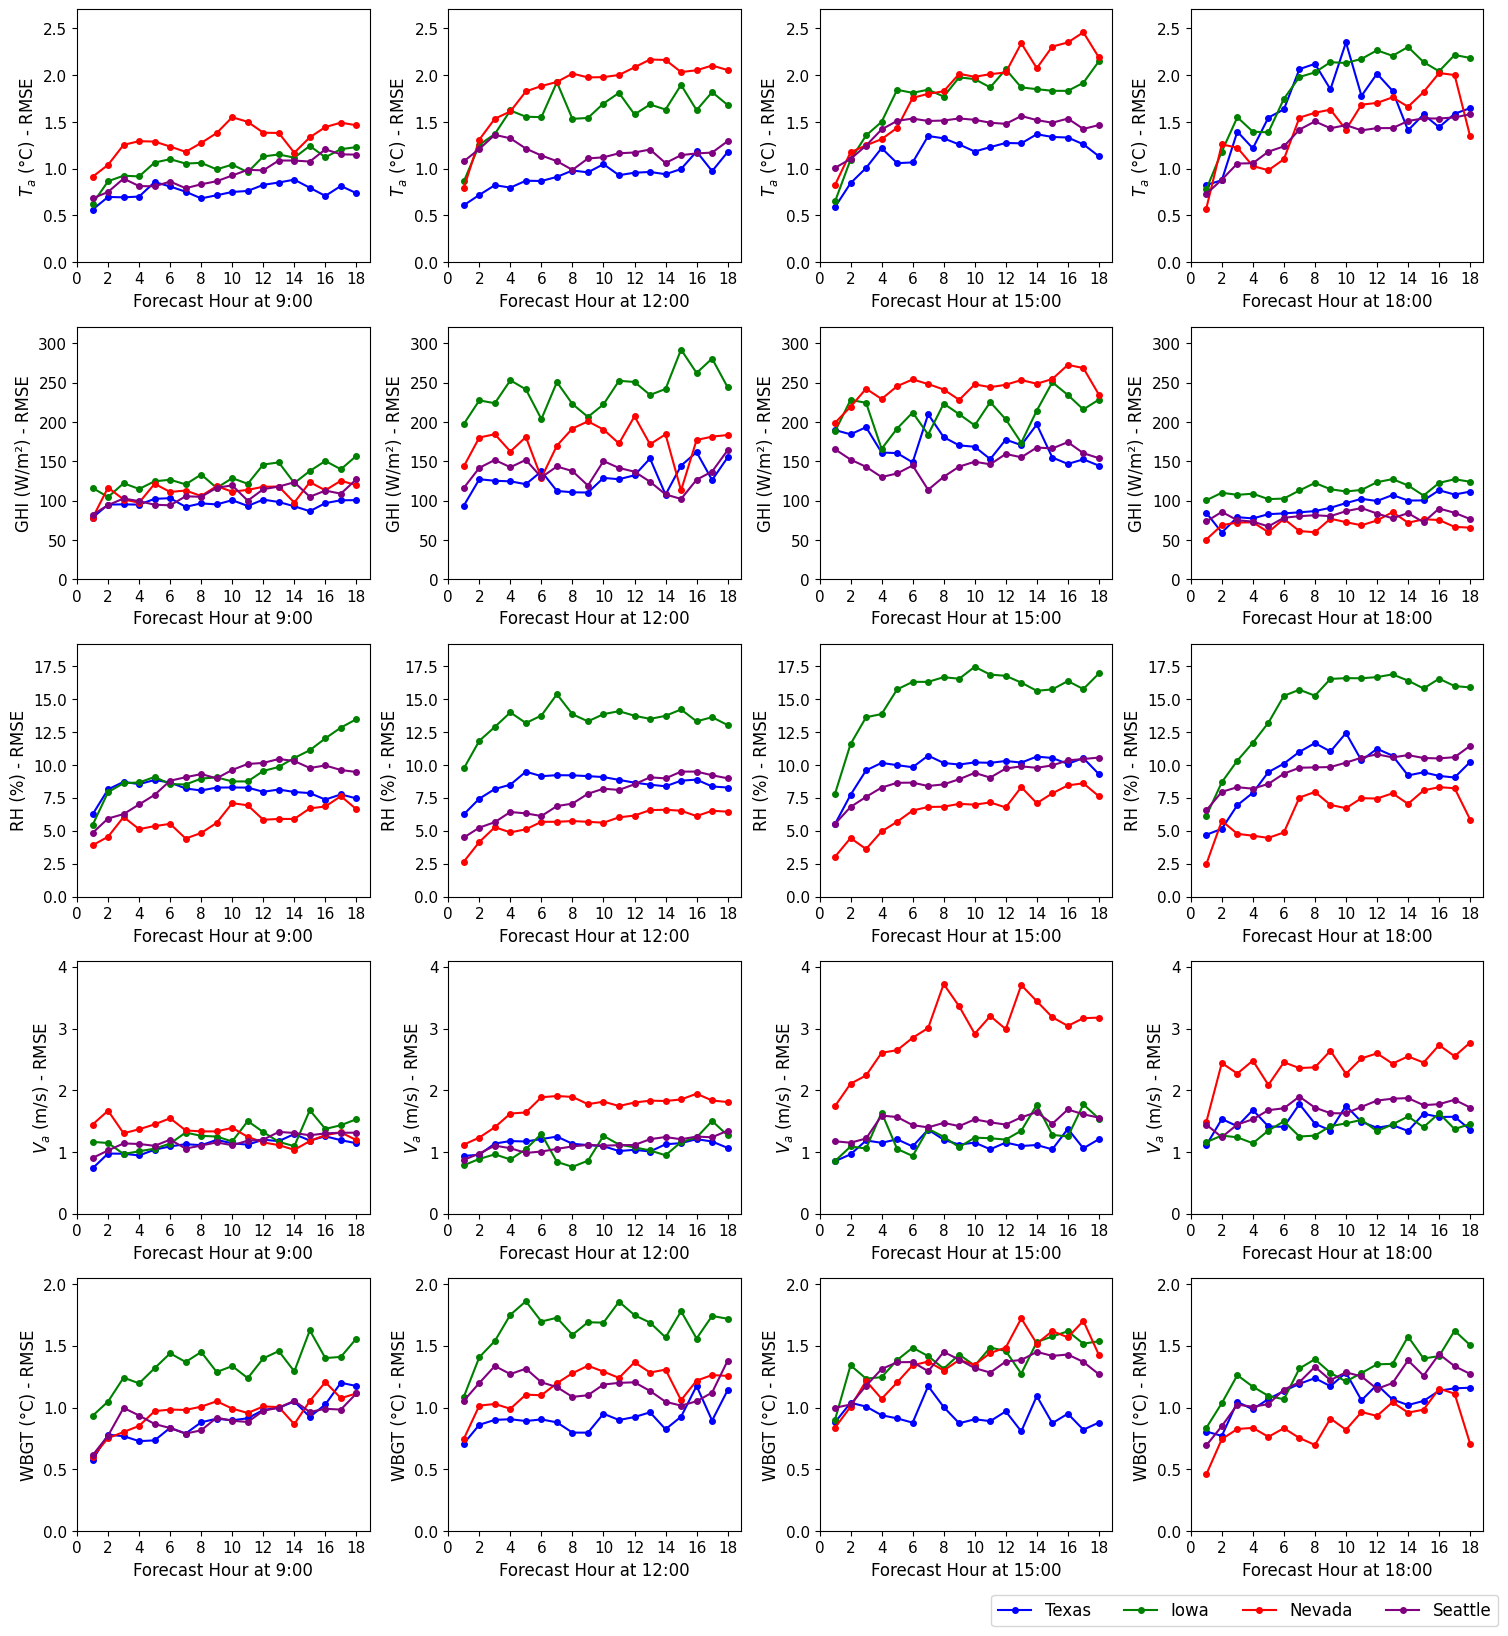

In [8]:
# List of DataFrame names (states) in a list
dfs_names = ['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']

# Define a color for each state
state_colors = {
    'df_Texas': 'blue',
    'df_Iowa': 'green',
    'df_Nevada': 'red',
    'df_Seattle': 'purple'
}

# State abbreviations
state_abbreviations = {
    'df_Texas': 'Texas',
    'df_Iowa': 'Iowa',
    'df_Nevada': 'Nevada',
    'df_Seattle': 'Seattle'
}

# Create subplots with a 5x4 grid layout
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 16))

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.8)

# List of specific hours for plotting
hours = [9, 12, 15, 18]

# LaTeX formatted variable names for plot labels
variables = [r"${T}_{a}$", 'GHI', r"RH", r"${V}_{a}$", 'WBGT']

# Units for each variable
units = {r"${T}_{a}$": '°C', 'GHI': 'W/m²', r"RH": '%', r"${V}_{a}$": 'm/s', 'WBGT': '°C'}

# Mapping from LaTeX formatted variable names to DataFrame column names
variable_column_mapping = {
    r"${T}_{a}$": 'ta (RMSE)',
    'GHI': 'GHI (RMSE)',
    r"RH": 'rh (RMSE)',
    r"${V}_{a}$": 'va (RMSE)',
    'WBGT': 'WBGT (RMSE)'
}

# Calculate maximum values for each variable across all DataFrames
max_values = {}
for var in variables:
    column_name = variable_column_mapping[var]
    max_values[var] = max(df[column_name].max() for df in dfs.values()) * 1.1

# Create empty lists to store legend handles and labels
handles_list = []

# Iterate over variables and specific hours for plotting
for j, var in enumerate(variables):
    for i, hour in enumerate(hours):
        ax = axes[j, i]  # Access the subplot
        
        # Turn off grid lines for the current subplot
        ax.grid(False)
        
        # Plot data for each state with smaller markers 'o'
        for df_name in dfs_names:
            df = dfs[df_name]  # Access the dataframe using its name
            filtered_df = df[df['hour'] == hour]
            
            # Retrieve the correct column name using the mapping
            column_name = variable_column_mapping[var]
            
            # Plot data and add it to the legend handles list
            line, = ax.plot(filtered_df['forecast_hour'], filtered_df[column_name],
                            label=state_abbreviations[df_name], color=state_colors[df_name], marker='o', markersize=4)
            
            # Add the handle for the legend if not already added
            if state_abbreviations[df_name] not in [h.get_label() for h in handles_list]:
                handles_list.append(line)

        # Set the y-axis limits
        ax.set_ylim(0, max_values[var])

        # Set x and y-axis labels for all subplots
        ax.set_xlabel(f'Forecast Hour at {hour}:00', fontsize=12)
        ax.set_ylabel(f'{var} ({units[var]}) - RMSE', fontsize=12)
        ax.tick_params(axis='y', labelsize=11)

        # Set the fontsize for x-axis tick labels
        ax.set_xticks(range(0, 19, 2))
        ax.tick_params(axis='x', labelsize=11)

# Create a single legend below the subplots at the center
fig.legend(handles_list, [h.get_label() for h in handles_list], loc='lower center', bbox_to_anchor=(0.83, -0.025), ncol=4, fontsize=12)

# Adjust the layout so the legend does not overlap with subplots
plt.tight_layout()

# Save the figure as a PNG file with high DPI
plt.savefig('./Result/RMSE_per_State_Variable_Hour.png', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()


### Plot MAE subplots

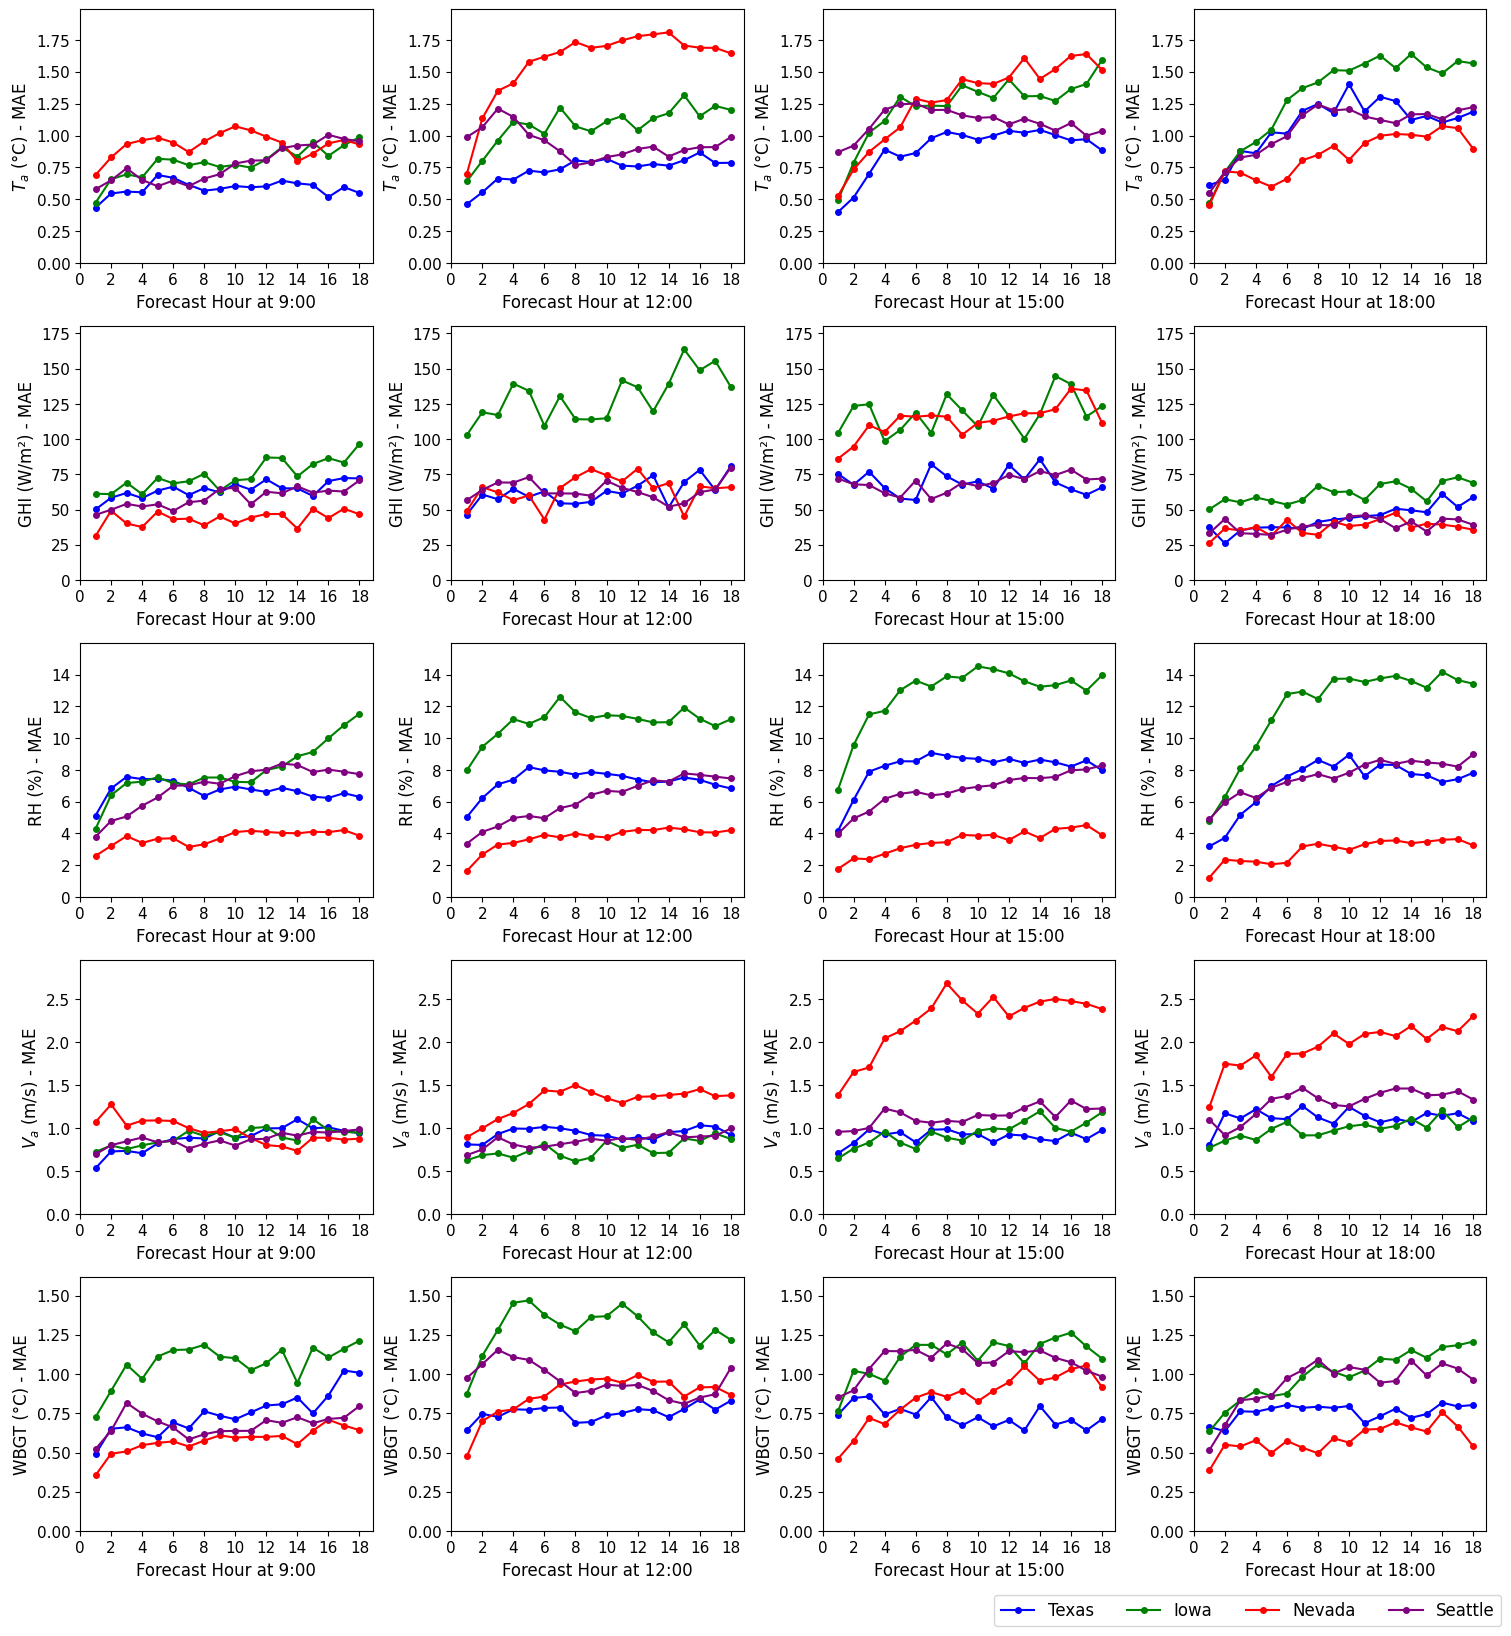

In [9]:
# List of DataFrame names (states) in a list
dfs_names = ['df_Texas', 'df_Iowa', 'df_Nevada', 'df_Seattle']

# Define a color for each state
state_colors = {
    'df_Texas': 'blue',
    'df_Iowa': 'green',
    'df_Nevada': 'red',
    'df_Seattle': 'purple'
}

# State abbreviations for labeling
state_abbreviations = {
    'df_Texas': 'Texas',
    'df_Iowa': 'Iowa',
    'df_Nevada': 'Nevada',
    'df_Seattle': 'Seattle'
}

# Create subplots with a 5x4 grid layout and specified figure size
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 16))

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.8)

# List of specific hours for plotting
hours = [9, 12, 15, 18]

# LaTeX formatted variable names for plot labels
variables = [r"${T}_{a}$", 'GHI', r"RH", r"${V}_{a}$", 'WBGT']

# Units for each variable
units = {r"${T}_{a}$": '°C', 'GHI': 'W/m²', r"RH": '%', r"${V}_{a}$": 'm/s', 'WBGT': '°C'}

# Mapping from LaTeX formatted variable names to DataFrame column names
variable_column_mapping = {
    r"${T}_{a}$": 'ta (MAE)',
    'GHI': 'GHI (MAE)',
    r"RH": 'rh (MAE)',
    r"${V}_{a}$": 'va (MAE)',
    'WBGT': 'WBGT (MAE)'
}

# Calculate maximum values for each variable across all DataFrames
max_values = {}
for var in variables:
    column_name = variable_column_mapping[var]
    max_values[var] = max(df[column_name].max() for df in dfs.values()) * 1.1

# Create empty lists to store legend handles and labels
handles_list = []

# Iterate over variables and specific hours for plotting
for j, var in enumerate(variables):
    for i, hour in enumerate(hours):
        ax = axes[j, i]  # Access the subplot
        
        # Turn off grid lines for the current subplot
        ax.grid(False)
        
        # Plot data for each state with smaller markers 'o'
        for df_name in dfs_names:
            df = dfs[df_name]  # Access the dataframe using its name
            filtered_df = df[df['hour'] == hour]
            
            # Retrieve the correct column name using the mapping
            column_name = variable_column_mapping[var]
            
            # Plot data and add it to the legend handles list
            line, = ax.plot(filtered_df['forecast_hour'], filtered_df[column_name],
                            label=state_abbreviations[df_name], color=state_colors[df_name], marker='o', markersize=4)
            
            # Add the handle for the legend if not already added
            if state_abbreviations[df_name] not in [h.get_label() for h in handles_list]:
                handles_list.append(line)

        # Set the y-axis limits
        ax.set_ylim(0, max_values[var])

        # Set x and y-axis labels for all subplots
        ax.set_xlabel(f'Forecast Hour at {hour}:00', fontsize=12)
        ax.set_ylabel(f'{var} ({units[var]}) - MAE', fontsize=12)
        ax.tick_params(axis='y', labelsize=11)

        # Set the fontsize for x-axis tick labels
        ax.set_xticks(range(0, 19, 2))
        ax.tick_params(axis='x', labelsize=11)

# Create a single legend below the subplots at the center
fig.legend(handles_list, [h.get_label() for h in handles_list], loc='lower center', bbox_to_anchor=(0.83, -0.025), ncol=4, fontsize=12)

# Adjust the layout so the legend does not overlap with subplots
plt.tight_layout()

# Save the figure as a PNG file with high DPI
plt.savefig('./Result/MAE_per_State_Variable_Hour.png', dpi=500, transparent=True, bbox_inches='tight')

# Display the plot
plt.show()